# Análisis de Sentimiento con NLTK

El análisis de sentimiento es una de las tareas más populares en NLP. Hay mucha literatura y casos prácticos que rodean este tema, por lo que también hay varios proveedores que ofrecen productos relacionados. Sin embargo, crear un módulo de análisis de sentimiento básico es relativamente sencillo. 

En este tutorial realizaremos un análisis de sentimiento para los *reviews* de celulares comprados en la plataforma AMAZON. El modelo de sentimiento está basado en algunos de los métodos que ofrece NLTK, los cuales se describen más adelante. 

# Empezamos cargando los datos

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [27]:
# Cargamos los datos 
url = 'https://raw.githubusercontent.com/patofw/imf_master/master/Notebooks/data/amazon_mobile_sales_short.csv'
data = pd.read_csv( url)
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,LG G3 Vigor D725 8GB Unlocked GSM 4G LTE Quad-...,LG,123.64,5,I like it,0.0
1,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,5,CNPGD All-in-1 Watch Cell Phone & Smart...CNPGD,0.0
2,Apple iPhone 5s 16GB (Space Gray) - Verizon Wi...,Apple,149.99,5,Thank you,0.0
3,BlackBerry Bold 9700 Unlocked GSM 3G World Pho...,BlackBerry,101.99,5,I bought 2sets.It arrived early enough as usua...,0.0
4,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,47.97,5,This is really a good Smartphone! It has been ...,0.0


In [28]:
# Describimos el dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  75000 non-null  object 
 1   Brand Name    75000 non-null  object 
 2   Price         74116 non-null  float64
 3   Rating        75000 non-null  int64  
 4   Reviews       74990 non-null  object 
 5   Review Votes  72910 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.4+ MB


In [29]:
data.drop('Review Votes', inplace=True, axis=1) # Eliminamos esta columna que no usaremos.
# eliminamos nulos por conveniencia 
data.dropna(inplace=True)

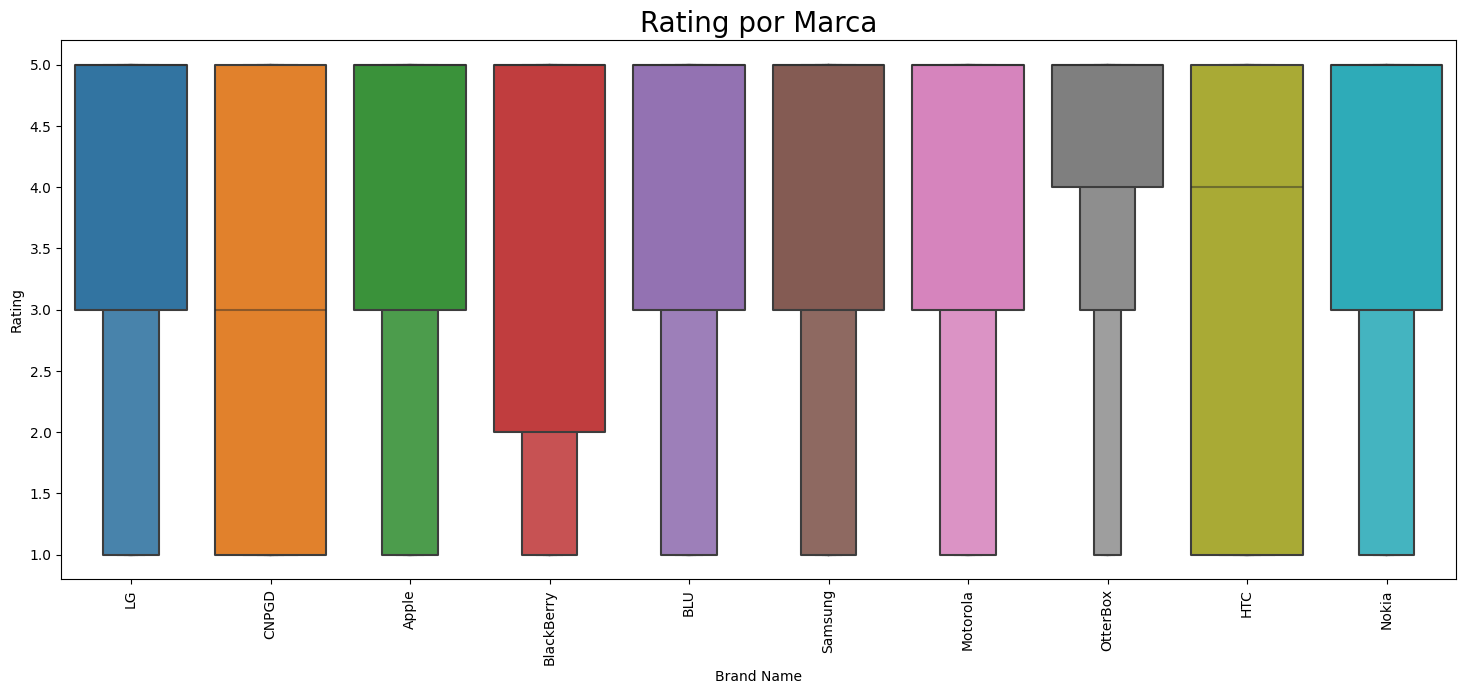

In [30]:
# Exploración rápida 
plt.rcParams['figure.figsize'] = (18, 7) # parametros de la viz
sns.boxenplot(data=data, 
            x='Brand Name',
            y='Rating')
plt.title('Rating por Marca', fontsize = 20)
plt.xticks(rotation='vertical')
plt.show();

<AxesSubplot:xlabel='Brand Name', ylabel='Rating'>

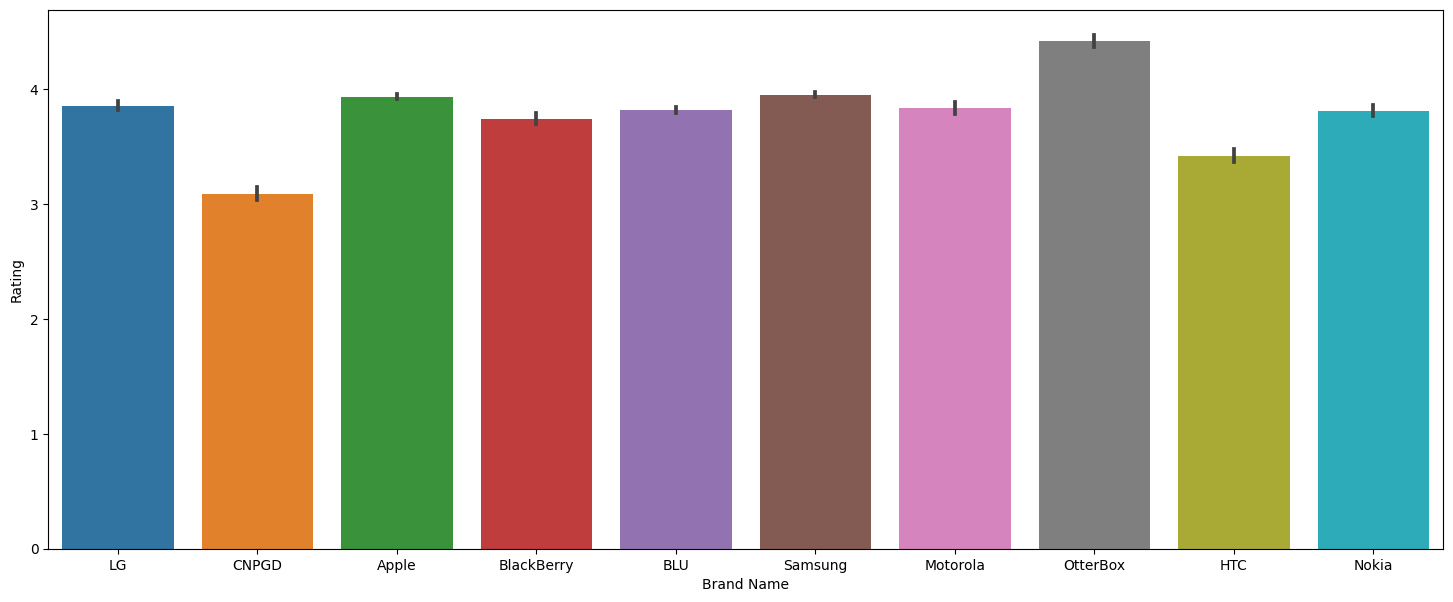

In [31]:
sns.barplot(data=data, 
            x='Brand Name',
            y='Rating')

<AxesSubplot:>

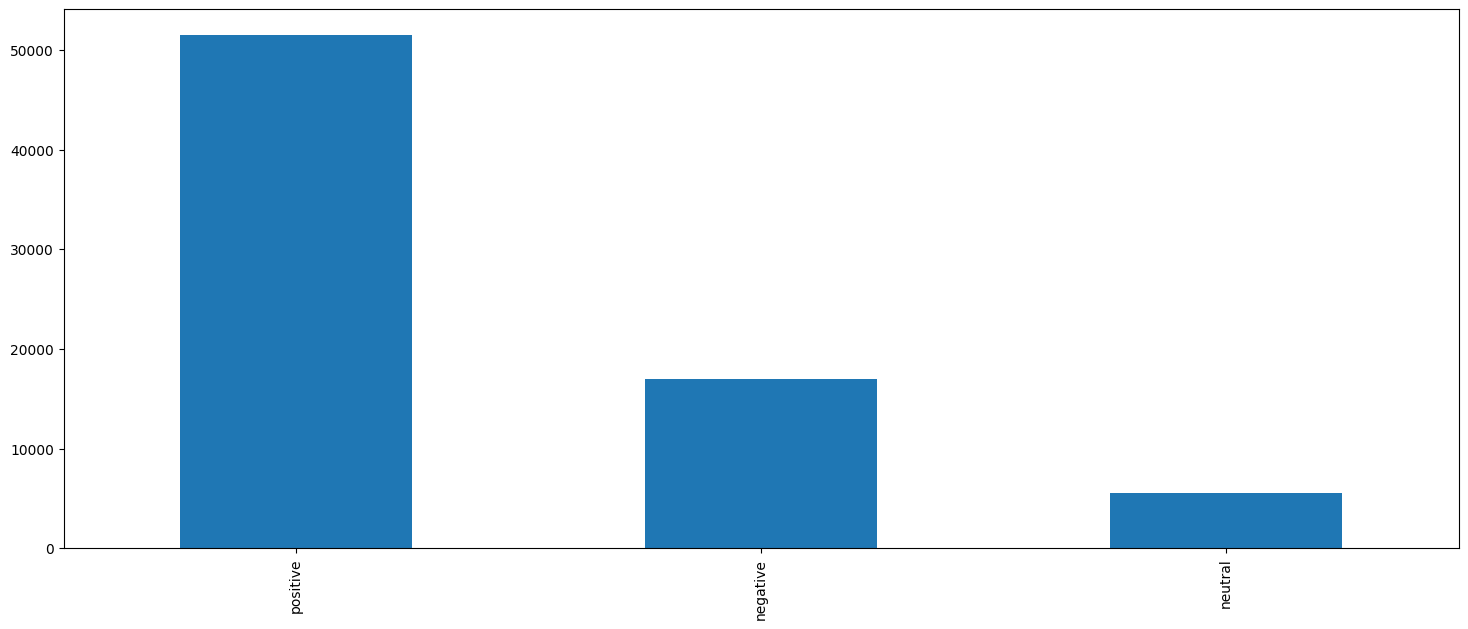

In [32]:
def map_labels(x: int):

    map_vals = {
        1: "negative",
        2: "negative",
        3: "neutral",
        4: "positive",
        5: "positive"
    }
    return map_vals.get(x)


data['labels'] = data.Rating.apply(map_labels)
data.labels.value_counts().plot(kind="bar")

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74106 entries, 0 to 74999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  74106 non-null  object 
 1   Brand Name    74106 non-null  object 
 2   Price         74106 non-null  float64
 3   Rating        74106 non-null  int64  
 4   Reviews       74106 non-null  object 
 5   labels        74106 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.0+ MB


In [35]:
# Selecciona las primeras 5K filas para reducir el tiempo de entrenamiento del modelo de predicción
data = data[:5000]

In [36]:
import re  # Procesamiento de Texto
from collections import defaultdict  

import spacy  # Procesamiento NLP
from spellchecker import SpellChecker

In [37]:
# Cargamos los métodos de Spacy en Ingles 
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # Quitamos el Named Entity Recognition por facilidad de procesamiento
spell = SpellChecker() # Corrector
# Reemplazos para Tweeter
replacements = [
            '((www\.[^\s]+)|(https?://[^\s]+))', # url_replace 
            '@[^\s]+', # user_replace 
            '#([^\s]+)', # hash_replace
            "[^A-Za-z' ]+"  # eliminamos todo lo que no sea una letra
            ]
# Re nos permite compilar varias transformaciones en un solo iterador, 
# así nos evitamos iterar varias veces por el mismo documento, incrementando eficiencia. 
regex = re.compile('|'.join(r for r in replacements),re.IGNORECASE)

def limpia_reviews(review,spellchecker=False): 
  """ 
  Función práctica para limpiar y pre-procesar tweets. Incluye: 
  - Eliminación de Hashtags, urls y usuarios 
  - Tokenización 
  - corrector gramatical (inglés)
  :param tweet: String, cadena de texto, idealmente un Tweet
  :return: Una lista con tokens de tweet.  
  """
  # empezamos transformando a minúsculas
  clean_review = review.lower()
  # Limpiamos Usuario, Urls y Hashtags
  clean_review = regex.sub('', clean_review)
  # Añadimos limpieza de caracteres repetidos
  clean_review = re.sub(r'(.)\1+', r'\1\1', clean_review).split()
  if spellchecker:
    # Encuentra las que tienen errores
    misspelled = spell.unknown(clean_review)
    # Corregimos el tweet. 
    clean_review = [
        spell.correction(word) if word in misspelled else word for word in clean_review]
  return ' '.join(clean_review)

In [38]:
def cleaning(doc):
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  
  txt = [token.lemma_ for token in doc if not token.is_stop]
  return ' '.join(txt)
# Funcion de limpieza del tweet que entrará al pipe de Spacy(NLP)
review_cleaning = (limpia_reviews(row) for row in data['Reviews'])

In [39]:
#Ejemplo
limpia_reviews('hapy panda day @snafranci, really enjoying this #Gloriousafternoon', True)

'happy panda day really enjoying this'

In [40]:
from time import time  # Medir tiempo de ejecucion
t = time() # Calculamos tiempo
txt = [cleaning(doc) for doc in nlp.pipe(review_cleaning, # función que def antes
                                         batch_size=5000, 
                                         n_process=-1 # usamos todos los cores
                                         )]
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

Tiempo de ejecución: 0.48 mins


In [41]:
txt[:4]

['like',
 'cnpgd allin watch cell phone smartcnpgd',
 'thank',
 "buy setsit arrive early usual content account happy purchasei read ' p ' key fall weeksi get point definitely update post negative crop highly recommend update device software use"]

In [42]:
data['clean_text'] = txt

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [44]:
X = data['clean_text']
y = data['labels']
# Dividimos entre set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42, stratify=y)

In [45]:
X_train.shape # Con cuantos puntos vamos a entrenar

(3500,)

In [46]:
# Creamos el Sklearn Pipeline con todas las transformaciones mencionadas arriba 
text_clf_rf = Pipeline([
  ('vect', CountVectorizer()), 
  ('tfidf', TfidfTransformer()), # transforma por frecuencia 
  ('clf_rf', RandomForestClassifier(n_estimators=100, 
                                    verbose=True, # Verbose -> barra progreso
    oob_score=True,min_samples_split=2))
               ])
# Realizamos un entrenamiento con CV para tener certeza de los resultados
# Y también poder probar cuál modelo es el mejor. 

scoring = "f1_micro" # metric to optimize can be 'recall'
cv = 3 # cross validation
parameters = { 
  'vect__ngram_range': [(1, 1), (1, 2)],
  'tfidf__use_idf': (True, False),
  'clf_rf__n_estimators': (200, 400),
  'clf_rf__min_samples_split': (2,4)
}

# Creamos todo el pipeline para que ademas ejecute cambio de parametros 
grid = GridSearchCV(text_clf_rf, cv=cv, param_grid=parameters, 
                    scoring=scoring, n_jobs = -1)

In [47]:
# Entrenamos 
grid.fit(X_train, y_train) # Toma TIEMPO!!! 

# summarize results
print(f"Resultados en base a {scoring}")
print("Mejor: %f usando %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score'] 
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Resultado medio: {mean}, SD: {stdev}  con: {param}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   33.0s finished


Resultados en base a f1_micro
Mejor: 0.818002 usando {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 400, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.8128567040144864, SD: 0.005358624248331119  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.8094298468019184, SD: 0.010291158902186405  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.8145722148486857, SD: 0.004627013304211052  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.80285882543728, SD: 0.011616651678161408  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.8122859285977101, SD: 0.004578578003860271  con: {'clf_rf__min_samples_split': 2

In [50]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.3s finished



accuracy 0.8093333333333333


              precision    recall  f1-score   support

    negative       0.77      0.58      0.66       340
     neutral       0.80      0.04      0.07       111
    positive       0.82      0.96      0.89      1049

    accuracy                           0.81      1500
   macro avg       0.80      0.53      0.54      1500
weighted avg       0.81      0.81      0.77      1500

Confusion matrix, without normalization


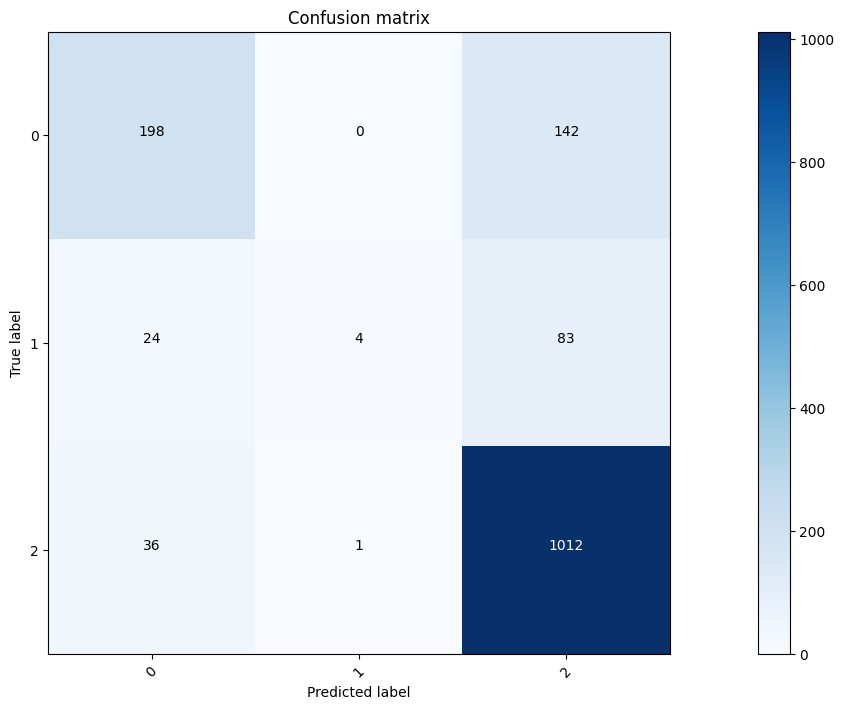

In [51]:
# Revisamos resultados del mejor modelo 
m_best = grid.best_estimator_ # mejor modelo
y_pred = m_best.predict(X_test)
# Metricas de precision
print('\naccuracy %s' % accuracy_score(y_pred, y_test))
print("\n")
print(classification_report(y_test, y_pred,))

# plot 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(3)))

In [54]:
# Veamos donde hemos fallado
# Show some misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]
i = np.random.choice(misclassified_idx)
print('id %s' %(i))
print(data['clean_text'].values[i])
print("Realmente es: %s Y se predijo: %s" % (y_test.values[i], y_pred[i]));

id 639
love phonefor worth itthe display great screen bright sharpsound great sound low drivingmy music sound great tooi love selfie cam especially flash camit look little funny oki love security feature get phone basically fingerprint scanner use feature scared illegal forget password tech stuff awesome plus picture vaultit thin light weightat disappoint size play well feel hand size perfectthe st day phone battery last day light use today phone hour social medium pandora usage end buy battery pack upthe phone speed fast love iti'm have issue app location phone sensitive gps work tell route work time gooverall great phone buy againi'm straight talk wireless live wooded area phone work great
Realmente es: neutral Y se predijo: positive


# El Corpus

Como siempre, realizaremos transformaciones que nos permitan limpiar el corpus. 

In [ ]:
data.Reviews.values[:5]

array(['I like it', 'CNPGD All-in-1 Watch Cell Phone & Smart...CNPGD',
       'Thank you',
       "I bought 2sets.It arrived early enough as usual. All the contents were accounted for and i am very happy with my purchase.I have read about the 'P' key falling off after 3weeks...i haven't yet gotten to that point but will definitely update my post if anything negative crops up. I highly recommend updating the device software before use!",
       'This is really a good Smartphone! It has been working perfectly! I have no complaints at all. Thank you!'],
      dtype=object)

In [ ]:
from time import time # Medimos tiempo de ejecución
import re 

import spacy

nlp = spacy.load('en', disable=['ner', 'parser']) # Quitamos el Named Entity Recognition por facilidad de procesamiento

def cleaning(doc):
    # Lemmatiza y elimina stopwords
    # Necesitamos un doc como lo describe spacy
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec usa el contexto para entender la reperesentacion de la palabra
    # Si la oracion es corta, no va a aprender mucho
    return ' '.join(txt)
# Reemplazamos todo lo que no sea alphanum
brief_cleaning = (re.sub(r"[^A-Za-z' ]+", ' ', 
                         str(row)).lower().strip() for row in data.Reviews)


In [ ]:
# Usamos el método Pipe de Spacy para procesar con mayor velocidad
t = time() # Calculamos tiempo

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, # función que def antes
                                         batch_size=5000, 
                                         n_threads=-1 # usamos todos los cores
                                         )]
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

Tiempo de ejecución: 1.65 mins


In [ ]:
txt[:5]

['like',
 'cnpgd   watch cell phone    smart cnpgd',
 'thank',
 "buy   set arrive early usual   content account happy purchase read ' p ' key fall   week get point definitely update post negative crop   highly recommend update device software use",
 'good smartphone   work perfectly   complaint   thank']

# El modelo de Sentimiento de NLTK 


NLTK tiene mucho desarrollo en el análisis de sentimiento. Es más, tiene un [módulo entero](https://www.nltk.org/api/nltk.sentiment.html) para este tipo de casos. 

Para este tutorial utilizaremos la función de SentimentIntensityAnalyzer que no solo devuelve un 'valor de sentimiento', pero también incluye otras funciones útiles como cálculo de la polaridad y diferentes formas de normalización de las valencias del cálculo. Además, incluye un diccionario de negaciones que hacen más robusta a esta solución. 

El algoritmo está basado en [VADER](https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text) (Valence Aware Dictionary and sEntiment Reasoner) que básicamente es un diccionario de palabras comúnmente utilizadas a las cuales se les asigna un valor de sentimiento ('Good':3, 'Bad':-3). 

Este sistema es práctico, simple y funciona. Sin embargo, no debe considerarse como el estado del arte en análisis de sentimiento. 

### Algunos retos a considerar: 
- Frases con doble intención: “The intent behind the movie was great, but it could have been better”.
- Sarcasmo : 'Great service!!! I had to wait for two hours on the phone. It shows that you really care for your customers!!. 
- Errores gramaticales
- Polaridad extrema (Sobre todo en política) 
- Bots y Trolls 
- *Slang* y dialectos. 


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [ ]:
# Ejemplo de uso
sent = SentimentIntensityAnalyzer()
sent.polarity_scores('It was a very good meal, Im happy')

{'compound': 0.7841, 'neg': 0.0, 'neu': 0.42, 'pos': 0.58}

In [ ]:
sent.polarity_scores('It hated it, worst experience of my life')

{'compound': -0.8519, 'neg': 0.58, 'neu': 0.42, 'pos': 0.0}

In [ ]:
from tqdm.notebook import tqdm # barra de progreso
# Extraemos los sentimientos de cada uno de los reviews
sentiments = [sent.polarity_scores(review) for review in tqdm(txt)]

In [ ]:
# Tenemos el diccionario completo, en caso de querer 
# Utilizar algunas de las otras valencias 
sentiments[:2]

[{'compound': 0.3612, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0},
 {'compound': 0.4019, 'neg': 0.0, 'neu': 0.649, 'pos': 0.351}]

In [ ]:
# Sacamos los valores 
values = [d['compound'] for d in sentiments]

In [ ]:
# Lo reinsertamos al dataset 
data['valor_sentimiento'] = values

In [ ]:
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,valor_sentimiento
0,LG G3 Vigor D725 8GB Unlocked GSM 4G LTE Quad-...,LG,123.64,5,I like it,0.3612
1,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,5,CNPGD All-in-1 Watch Cell Phone & Smart...CNPGD,0.4019
2,Apple iPhone 5s 16GB (Space Gray) - Verizon Wi...,Apple,149.99,5,Thank you,0.3612
3,BlackBerry Bold 9700 Unlocked GSM 3G World Pho...,BlackBerry,101.99,5,I bought 2sets.It arrived early enough as usua...,0.6697
4,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,47.97,5,This is really a good Smartphone! It has been ...,0.8126


## Revisamos resultados

In [ ]:
# Correlación 
data[['valor_sentimiento','Rating']].corr()

,valor_sentimiento,Rating
valor_sentimiento,1.000000,0.537247
Rating,0.537247,1.000000


In [ ]:
data.groupby('Rating')['valor_sentimiento'].mean()

Rating
1   -0.082085
2    0.121143
3    0.317204
4    0.526211
5    0.573033
Name: valor_sentimiento, dtype: float64

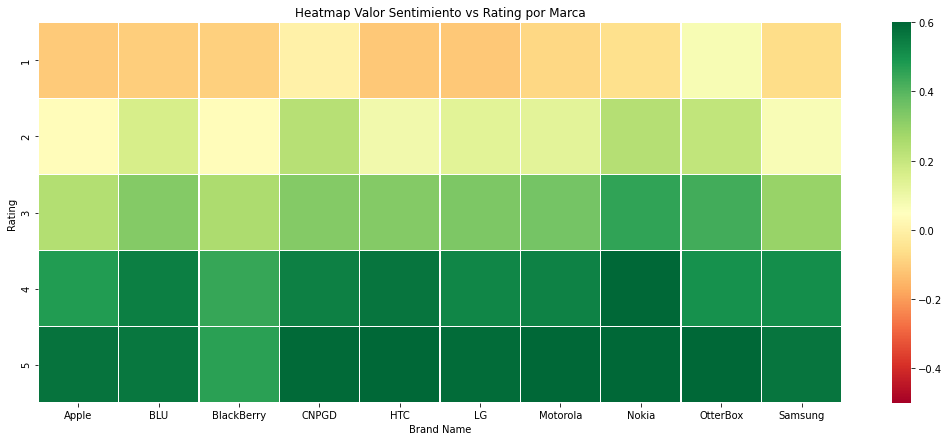

In [ ]:
# Visualizamos la relación con un mapa de calor 
g = data.groupby(['Rating','Brand Name'])['valor_sentimiento'].mean().unstack()
sns.heatmap(g,
            linewidths=.5, 
            cmap="RdYlGn", 
            vmin = -0.5,
            vmax = .6)
plt.title('Heatmap Valor Sentimiento vs Rating por Marca');

In [ ]:
data.sort_values('Rating').head(10)

,Product Name,Brand Name,Price,Rating,Reviews,valor_sentimiento
74999,LG Nexus 5X Unlocked Smartphone - White 32GB (...,LG,399.00,1,The sim card holder could not hold sim card ti...,0.0000
31909,LG A275 Black Unlocked GSM Dual SIM QuadBand C...,LG,50.50,1,junk. dual sim but none of the slots work. too...,0.6705
31908,Samsung Galaxy S4 i9505 16GB LTE Unlocked Inte...,Samsung,168.68,1,when ı get ıt and arrıved ın turkey started to...,-0.9217
57611,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,77.99,1,This was one of the worst products I ever boug...,-0.2023
57612,Motorola Droid 3 Verizon Xt862 Verizon Cell Phone,Motorola,99.99,1,"It never pick up wifi, drop calls and i have a...",-0.2732
12130,Samsung Galaxy S II Skyrocket I727 16GB Unlock...,Samsung,69.99,1,the phone supposed to be a new phone but it is...,-0.6705
31903,Samsung Galaxy J7 SM- J700H/DS GSM Smartphone-...,Samsung,208.00,1,I just got the phone and I thought that I can ...,0.0000
12134,Blu Dash JR D141W Dual Sim Factory Unlocked An...,BLU,40.00,1,Worst phone ever,-0.5423
12135,BlackBerry 8520 Unlocked Phone with 2 MP Camer...,BlackBerry,32.95,1,"I bought this phone in March of this year, thi...",-0.7239
57616,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,77.99,1,the phone froze on blu logo and there has not ...,-0.0516


In [ ]:
data.sort_values('Rating', ascending=False).head(10)

,Product Name,Brand Name,Price,Rating,Reviews,valor_sentimiento
0,LG G3 Vigor D725 8GB Unlocked GSM 4G LTE Quad-...,LG,123.64,5,I like it,0.3612
42578,Apple iPhone 4 32GB (Black) - Verizon,Apple,69.98,5,This item was exactly as advertised-in perfect...,0.9186
42565,BlackBerry Storm 2 9550 Unlocked Phone - No Wa...,BlackBerry,79.99,5,EXCELLENT,0.5719
42566,BLU Life XL - LTE Smartphone - GSM Unlocked - ...,BLU,129.99,5,Product works as expected,0.0000
42567,BLU PURE XL Smartphone - 4G LTE GSM Unlocked -...,BLU,134.95,5,Great phone for the price and easy to use and ...,0.7906
42569,Samsung Galaxy J7 SM- J700H/DS GSM Smartphone-...,Samsung,208.00,5,very good,0.4404
42571,Apple iPhone 5c 32GB (White) - Sprint,Apple,235.16,5,Great just what I hoped for. Love Amazon marke...,0.9169
42572,Samsung Galaxy S4 SGH-I337 Unlocked GSM Smartp...,Samsung,288.89,5,"looked great, worked wonderfully",0.8402
42573,"Blackberry Z30 Unlocked Cellphone, 16GB, Black",BlackBerry,249.99,5,First one had battery problems but the replace...,0.3400
42574,OtterBox 'Defender Series' Rugged and Protecti...,OtterBox,16.90,5,Great protection,0.6249


### Veamos en donde hubo fallos en la predicción

In [ ]:
missed = data[data['Rating'] == 1].sort_values(
    'valor_sentimiento', ascending = False).head(10)
missed

,Product Name,Brand Name,Price,Rating,Reviews,valor_sentimiento
45375,Nokia C3-01 Unlocked Touch and Type GSM Phone-...,Nokia,269.10,1,UPDATE! I had one of the first reviews for thi...,0.9983
14843,Moto G Play (4th gen.) - Black - 16 GB - Unloc...,Motorola,149.99,1,"I will continue this review, but right now thi...",0.9970
29483,Blu LIFE 8 Unlocked (White),BLU,169.99,1,UPDATE:Don't buy this crap. A month after my 6...,0.9966
71594,Blu LIFE 8 Unlocked (Pink),BLU,199.98,1,UPDATE:Don't buy this crap. A month after my 6...,0.9966
26139,BLU Studio 5.0 C HD Smartphone - Unlocked - Ye...,BLU,2000.00,1,I have had this phone for a week and am quite ...,0.9963
43585,"Blu Studio C Mini Quad Core, 4.7"" IPS, Android...",BLU,79.99,1,I've rated with one star because I received th...,0.9905
40342,BLU PURE XL Smartphone - 4G LTE GSM Unlocked -...,BLU,129.99,1,Phone looks good and functions excellent. Scre...,0.9900
26898,"BLU Studio 6.0 Unlocked Cellphone, Black",BLU,292.99,1,I purchased this phone because of the big disp...,0.9892
3242,"BLU Studio 6.0 Unlocked Cellphone, White",BLU,971.60,1,I purchased this phone because of the big disp...,0.9892
51177,Samsung Galaxy S5 SM-G900F 16GB Factory Unlock...,Samsung,199.00,1,"WOW, WOW, WOW...I'm so terribly disappointed w...",0.9882


In [ ]:
missed['Reviews'].values[2]

'UPDATE:Don\'t buy this crap. A month after my 6 month warranty expired: - My wife\'s stopped charging. Touch screen randomly throws a fit and freaks out. - Mine, the speakerphone is completely dead/blew in it. Touchscreen issues as well.----------------My wife purchased the pink Blu Life 8 for herself about a week ago, after smashing her Samsung accidentally. She did about a full days worth of looking through different phones, and all the the different Blu brand phones (5.5, 6, 7, and 8) and she decided to spend the extra bucks for the 8. I work in IT and I was really impressed with the 8-core processor, and screen size for the price. It lacks the RAM of the super-high end phone but it sounded like a great amount of processing power. I was a little worried about battery life, but it\'s what she wanted and seemed reasonable enough.She received it and has been ecstatic with it so far. We had a little weirdness with the wifi initially. For some reason the OS kept setting itself to use a 

In [ ]:
sent.polarity_scores

'great product   recommend'

In [ ]:
sent.polarity_scores(missed['Reviews'].values[2])

{'compound': 0.999, 'neg': 0.056, 'neu': 0.806, 'pos': 0.138}

# Añadimos polaridad 

In [ ]:
data['positivos'] = [d['pos'] for d in sentiments]
data['negativos'] = [d['neg'] for d in sentiments]


In [ ]:
data.corr()

,Price,Rating,valor_sentimiento,positivos,negativos
Price,1.000000,0.065987,0.033781,0.063587,-0.027952
Rating,0.065987,1.000000,0.537247,0.504891,-0.425191
valor_sentimiento,0.033781,0.537247,1.000000,0.589953,-0.581227
positivos,0.063587,0.504891,0.589953,1.000000,-0.392113
negativos,-0.027952,-0.425191,-0.581227,-0.392113,1.000000


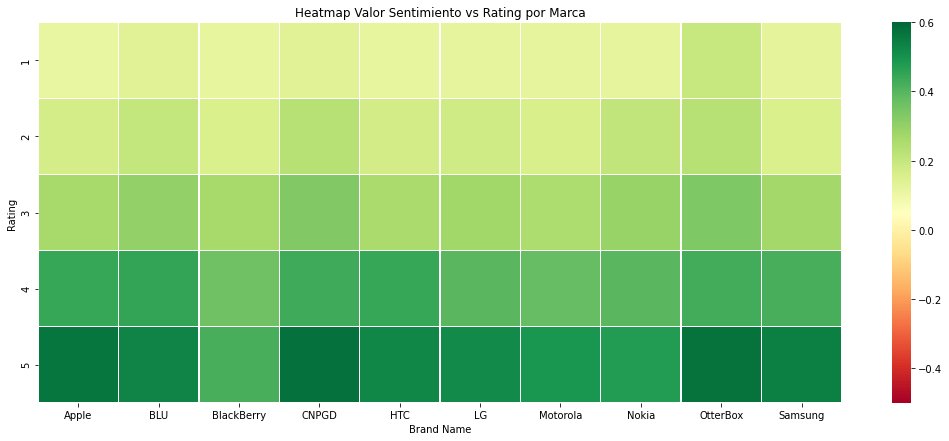

In [ ]:
# Visualizamos la relación con un mapa de calor 
g = data.groupby(['Rating','Brand Name'])['positivos'].mean().unstack()
sns.heatmap(g,
            linewidths=.5, 
            cmap="RdYlGn", 
            vmin = -0.5,
            vmax = .6)
plt.title('Heatmap Valor Sentimiento vs Rating por Marca');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


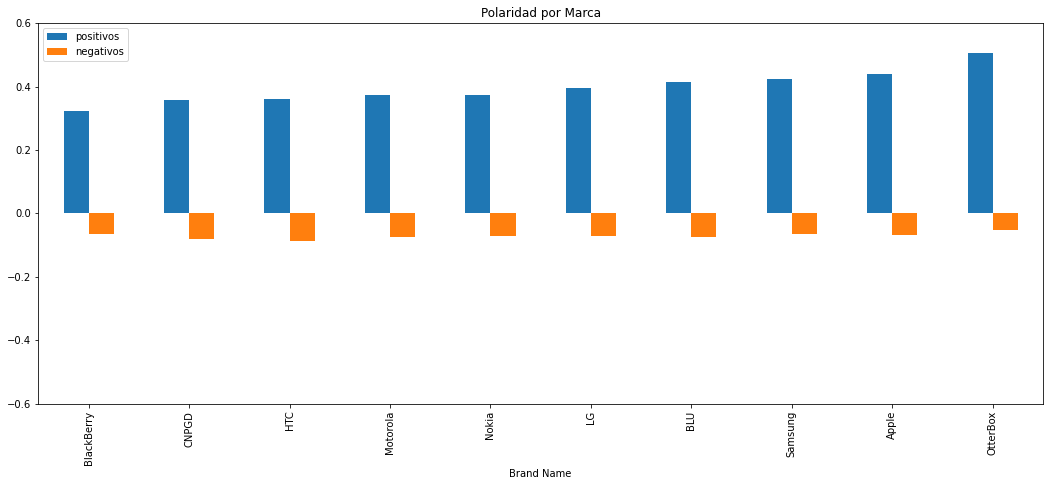

In [ ]:
g = data.groupby(['Brand Name'])[
  'positivos','negativos'].mean().sort_values('positivos')
                             
g['negativos'] = g['negativos']*-1                       
g.plot(kind='bar')
plt.ylim(-.6,.6)
plt.title('Polaridad por Marca')
plt.show();